In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import torch
import torch.nn as nn
import torch_geometric as pyg
import torch_geometric.nn as gnn

/mnt/c/Users/nck/repos/GNN-Plus/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_style('darkgrid')
np.random.seed(42)

# Dataset

In [3]:
# Get graph
data_folder = './data/training_matrices_DGL/'
mat = pd.read_csv(data_folder + 'Astrocyte.feat.mat', index_col=0, sep='\t')
genes = np.array(mat.columns)
assert (genes == np.array(mat.index)).all()

# Get labels
meta = pd.read_csv(data_folder + 'training_labels.txt', index_col=0, sep='\t')
labels = meta.values[:, 0]
labels = np.array([str(meta.loc[g]['label']) if g in meta.index else 'unknown' for g in genes])

### SUBSET
# subset_idx = np.random.choice(len(labels), 1000, replace=False)
ad_labels = np.argwhere(labels == 'AD').flatten()
notad_labels = np.argwhere(labels == 'notAD').flatten()
unknown_labels = np.argwhere(labels == 'unknown').flatten()
subset_idx = np.concatenate([
    np.random.choice(ad_labels, 100, replace=False),
    np.random.choice(notad_labels, 500, replace=False),
    np.random.choice(unknown_labels, 500, replace=False)])
mat = mat.iloc[subset_idx, subset_idx]
genes = genes[subset_idx]
labels = labels[subset_idx]
###

# Sort labels
ad_labels = np.argwhere(labels == 'AD').flatten()
notad_labels = np.argwhere(labels == 'notAD').flatten()
unknown_labels = np.argwhere(labels == 'unknown').flatten()
known_labels = np.array(list(set(range(len(genes))) - set(unknown_labels)))

# Split into training and testing
train_num = int(len(genes) * .8)
val_num = len(genes) - train_num
train_idx = np.random.choice(len(genes), train_num, replace=False)
val_idx = np.array(list(set(range(len(genes))) - set(train_idx)))

# Masks
train_mask = [i in train_idx for i in range(len(genes))]
val_mask = [i in val_idx for i in range(len(genes))]

# Format sparse
mat = scipy.sparse.coo_matrix(mat.values)
edge_indices = np.stack([mat.row, mat.col])
edge_weights = mat.data

# Construct dataset
data = pyg.data.Data(
    y=labels,
    edge_index=torch.tensor(edge_indices).to(torch.int64),
    edge_attributes=torch.tensor(edge_weights).to(torch.float64),
    train_mask=train_mask,
    val_mask=val_mask)
data

# Example dataset
# from torch_geometric.datasets import Planetoid
# dataset = Planetoid('./data', 'Cora')[0]
# dataset
# row, col = data.edge_index
# print(col.dtype)
# row, col = dataset.edge_index
# print(col.dtype)

Data(edge_index=[2, 477034], y=[1100], edge_attributes=[477034], train_mask=[1100], val_mask=[1100])

# Embedding Model

In [4]:
embedding_dim = 32

In [5]:
# Create model
model = gnn.Node2Vec(
    data.edge_index,
    embedding_dim=embedding_dim,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1,
    q=1,
    sparse=True)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(model.parameters(), lr=0.01)

In [6]:
# Train model
model.train()

def train():
    epoch_loss = 0
    for pos, neg in loader:
        loss = model.loss(pos, neg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach()
    return epoch_loss / len(loader)

for i in range(11):
    epoch_loss = train()
    if i % 2 == 0:
        print(f'Epoch {i} Loss: {epoch_loss:.3f}')
model.eval();

Epoch 0 Loss: 4.466
Epoch 2 Loss: 3.358
Epoch 4 Loss: 2.481
Epoch 6 Loss: 1.941
Epoch 8 Loss: 1.667
Epoch 10 Loss: 1.576


# AD Prediction

In [7]:
# Create model
class FCL(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.fcl = nn.Linear(self.input_dim, self.output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, X):
        return self.sigmoid(self.fcl(X))
    
ad_model = FCL(embedding_dim)
ad_optimizer = torch.optim.Adam(ad_model.parameters(), lr=1e-2)
ad_criterion = nn.MSELoss()

In [8]:
# Train model
batch_size = 128
batches = data.edge_index.shape[1] // batch_size
z = model()
ad_model.train()
for i in range(101):
    epoch_loss = 0
    for j in range(batches):
        seg_size = int(batch_size / 2)
        ad_batch_idx = np.random.choice(np.intersect1d(ad_labels, train_idx), seg_size, replace=True)
        notad_batch_idx = np.random.choice(np.intersect1d(notad_labels, train_idx), seg_size, replace=True)
        batch_idx = np.concatenate([ad_batch_idx, notad_batch_idx])
        
        true = torch.cat([torch.ones((seg_size, 1)), torch.zeros((seg_size, 1))])
        logits = ad_model(z[batch_idx])
        loss = ad_criterion(logits, true)
        loss.backward()
        ad_optimizer.step()
        epoch_loss += loss.detach()
    epoch_loss /= batches
    if i % 10 == 0:
        print(f'Epoch {i} Loss: {epoch_loss:.3f}')
ad_model.eval();

Epoch 0 Loss: 0.287
Epoch 10 Loss: 0.251
Epoch 20 Loss: 0.248
Epoch 30 Loss: 0.248
Epoch 40 Loss: 0.248
Epoch 50 Loss: 0.248
Epoch 60 Loss: 0.248
Epoch 70 Loss: 0.249
Epoch 80 Loss: 0.248
Epoch 90 Loss: 0.249
Epoch 100 Loss: 0.249


# Results

In [9]:
# Predictions
pred_val = ad_model(model())
pred = np.array(['AD' if ad else 'notAD' for ad in (pred_val > .5)])

# Printout
print('GENE\tPRED\tVALUE\tTRUE')
for i in np.random.choice(np.intersect1d(ad_labels, val_idx), 10, replace=True):
    print(f'{genes[i]}\t{pred[i]}\t{float(pred_val[i].detach()):.3f}\tAD')
print()
print('GENE\tPRED\tVALUE\tTRUE')
for i in np.random.choice(np.intersect1d(notad_labels, val_idx), 10, replace=True):
    print(f'{genes[i]}\t{pred[i]}\t{float(pred_val[i].detach()):.3f}\tnotAD')
print()
print('GENE\tPRED\tVALUE\tTRUE')
for i in np.random.choice(unknown_labels, 10, replace=True):
    print(f'{genes[i]}\t{pred[i]}\t{float(pred_val[i].detach()):.3f}\tunknown')

# Write enrichment genes to files
ad_enrichment = genes[np.intersect1d(np.argwhere(pred == 'AD'), val_idx)]
notad_enrichment = genes[np.intersect1d(np.argwhere(pred == 'notAD'), val_idx)]
np.savetxt('AD.txt', ad_enrichment, fmt='%s')
np.savetxt('notAD.txt', notad_enrichment, fmt='%s')

GENE	PRED	VALUE	TRUE
TFAM	notAD	0.000	AD
CASS4	notAD	0.000	AD
CDK5	AD	1.000	AD
CASP8	notAD	0.000	AD
MAP2	notAD	0.000	AD
ABCA1	notAD	0.000	AD
IDE	AD	1.000	AD
TFAM	notAD	0.000	AD
CASP8	notAD	0.000	AD
BCL2	AD	1.000	AD

GENE	PRED	VALUE	TRUE
FGFR3	notAD	0.000	notAD
CRKL	notAD	0.000	notAD
MYLK	notAD	0.000	notAD
GLI1	notAD	0.000	notAD
CEP57	notAD	0.000	notAD
FLT4	AD	1.000	notAD
FLT4	AD	1.000	notAD
ARHGEF18	notAD	0.000	notAD
CNDP1	notAD	0.000	notAD
DNMT3B	notAD	0.000	notAD

GENE	PRED	VALUE	TRUE
SLC12A6	AD	1.000	unknown
FOXD2	notAD	0.000	unknown
RBP5	notAD	0.000	unknown
ZNF395	notAD	0.000	unknown
CNTN1	notAD	0.000	unknown
TLE2	notAD	0.000	unknown
RBL2	AD	1.000	unknown
WDR45	notAD	0.000	unknown
TLK1	notAD	0.000	unknown
HSPBP1	AD	1.000	unknown


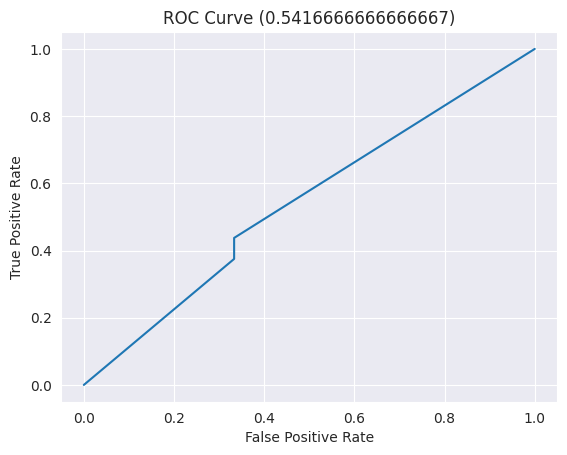

In [10]:
# ROC Curve
eval_idx = np.intersect1d(val_idx, known_labels)
fpr, tpr, thresholds = roc_curve(1.*(labels[eval_idx] == 'AD'), pred_val[eval_idx].detach())
plt.plot(fpr, tpr)
plt.title(f'ROC Curve ({auc(fpr, tpr)})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');